<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Стационарность-рядов" data-toc-modified-id="Стационарность-рядов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Стационарность рядов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Создание-выборок" data-toc-modified-id="Создание-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание выборок</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from random import randint
from sklearn.model_selection import GridSearchCV
from random import randint

In [2]:
RANDOM_STATE = 12345
RMSE_LIMIT = 48

In [3]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.sort_index(inplace=True)
print('Даты и время расположены в хронологическом порядке:', data.index.is_monotonic)

Даты и время расположены в хронологическом порядке: True


In [5]:
df = data.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df_shape = df.shape[0]
df_shape

4416

## Анализ

In [7]:
decomposed = seasonal_decompose(df)

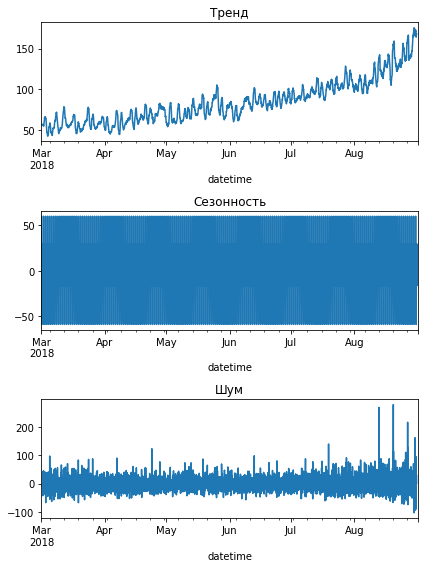

In [8]:
plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

Общий тренд: заказы такси росли в течение года.

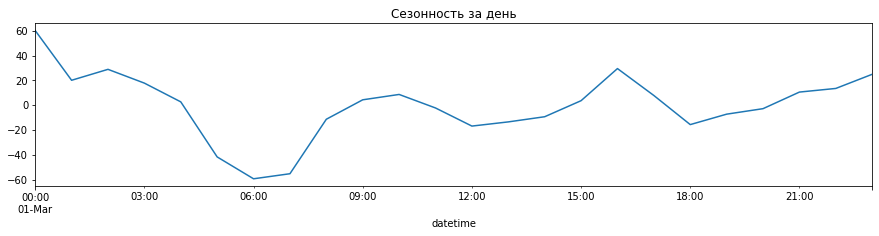

In [9]:
#код ревьюера
# график сезонности за день

decomposed.seasonal['2018-03-01':'2018-03-01'].plot(figsize = (15,3))
plt.title('Сезонность за день');



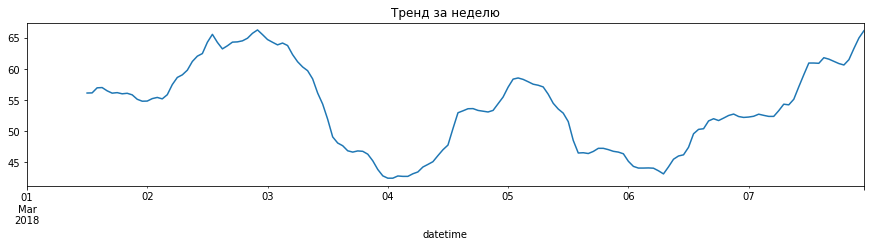

In [10]:
decomposed.trend['2018-03-01':'2018-03-07'].plot(figsize = (15,3)) # тренд за неделю
plt.title('Тренд за неделю');

<div class="alert alert-success">
   
   По графику отлично виден тренд с апреля по май, потом небольшое снижение в конце-мая и начале июня, затем снова положительный тренд до конца июля, небольшое снижение в начале августа и сильный рост в течение оставшейся части августа.

</div>


<div class="alert alert-info">
   
Рассмотрели также сезонность в течение суток и тренд в течение недели - так можно будет заметить некоторые закономерности в спросе на такси.

</div>


### Стационарность рядов

Нулевая гипотеза: ряд не является стацирнарным.

Альтернативная гипотеза: ряд является стационарным.

In [11]:
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, regression='ctt')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print()
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)
        
    if dftest[0] < dftest[4]["5%"]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

In [12]:
# Применяем к временному ряду
result = adf_test(df['num_orders'])

Результаты теста Дики-Фуллера:

Test Statistic                -1.089145e+01
p-value                        4.054940e-17
#Lags Used                     3.100000e+01
Number of Observations Used    4.384000e+03
Critical Value (1%)           -4.373775e+00
Critical Value (5%)           -3.833738e+00
Critical Value (10%)          -3.554095e+00
dtype: float64
Нулевая гипотеза отвергнута – Временной ряд стационарен


In [13]:
# Сделаем ряд более стационарным для облегчения прогноза
df -= df.shift()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,-39.0
2018-03-01 02:00:00,-14.0
2018-03-01 03:00:00,-5.0
2018-03-01 04:00:00,-23.0


<div class="alert alert-info">
   
   Сделала ряд более стационарным - взяла разности временного ряда.

</div>

## Обучение

### Создание признаков

In [14]:
def make_features(max_lag):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

<div class="alert alert-info">
   
   1. Добавила календарные признаки: месяц и день недели заказа.
   2. Также добавила признаки со средней суммой заказов за сутки и неделю (основываясь на новом графике сезонности)


</div>

In [15]:
make_features(15)
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

In [16]:
df['rolling_mean_day'] = df['num_orders'].rolling(24).mean()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   num_orders        4415 non-null   float64
 1   lag_1             4414 non-null   float64
 2   lag_2             4413 non-null   float64
 3   lag_3             4412 non-null   float64
 4   lag_4             4411 non-null   float64
 5   lag_5             4410 non-null   float64
 6   lag_6             4409 non-null   float64
 7   lag_7             4408 non-null   float64
 8   lag_8             4407 non-null   float64
 9   lag_9             4406 non-null   float64
 10  lag_10            4405 non-null   float64
 11  lag_11            4404 non-null   float64
 12  lag_12            4403 non-null   float64
 13  lag_13            4402 non-null   float64
 14  lag_14            4401 non-null   float64
 15  lag_15            4400 non-null   float64
 16

### Создание выборок

In [18]:
train, untrain = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(untrain, shuffle=False, test_size=0.5)
train = train.dropna()
train.isna().sum()

num_orders          0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
lag_5               0
lag_6               0
lag_7               0
lag_8               0
lag_9               0
lag_10              0
lag_11              0
lag_12              0
lag_13              0
lag_14              0
lag_15              0
dayofweek           0
hour                0
rolling_mean_day    0
dtype: int64

In [19]:
train_shape = train.shape[0]
print(f'Удалено из обучающей выборки: {1 - train_shape / df_shape:.0%}')

Удалено из обучающей выборки: 21%


In [20]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

display(features_train.head())
display(target_train.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,dayofweek,hour,rolling_mean_day
datetime,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,-55.0,47.0,5.0,16.0,-28.0,29.0,1.0,-23.0,18.0,16.0,2.0,-66.0,32.0,-5.0,35.0,4,0,-1.416667
2018-03-02 01:00:00,32.0,-55.0,47.0,5.0,16.0,-28.0,29.0,1.0,-23.0,18.0,16.0,2.0,-66.0,32.0,-5.0,4,1,1.458333
2018-03-02 02:00:00,30.0,32.0,-55.0,47.0,5.0,16.0,-28.0,29.0,1.0,-23.0,18.0,16.0,2.0,-66.0,32.0,4,2,0.166667
2018-03-02 03:00:00,-45.0,30.0,32.0,-55.0,47.0,5.0,16.0,-28.0,29.0,1.0,-23.0,18.0,16.0,2.0,-66.0,4,3,-0.083333
2018-03-02 04:00:00,-11.0,-45.0,30.0,32.0,-55.0,47.0,5.0,16.0,-28.0,29.0,1.0,-23.0,18.0,16.0,2.0,4,4,-0.958333


datetime
2018-03-02 00:00:00    32.0
2018-03-02 01:00:00    30.0
2018-03-02 02:00:00   -45.0
2018-03-02 03:00:00   -11.0
2018-03-02 04:00:00   -44.0
Freq: H, Name: num_orders, dtype: float64

In [21]:
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

display(features_valid.head())
display(target_valid.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,dayofweek,hour,rolling_mean_day
datetime,,,,,,,,,,,,,,,,,,
2018-07-26 04:00:00,-56.0,124.0,-76.0,11.0,54.0,-26.0,-1.0,-26.0,69.0,-53.0,-13.0,15.0,24.0,-4.0,16.0,3,4,0.291667
2018-07-26 05:00:00,-10.0,-56.0,124.0,-76.0,11.0,54.0,-26.0,-1.0,-26.0,69.0,-53.0,-13.0,15.0,24.0,-4.0,3,5,0.583333
2018-07-26 06:00:00,-48.0,-10.0,-56.0,124.0,-76.0,11.0,54.0,-26.0,-1.0,-26.0,69.0,-53.0,-13.0,15.0,24.0,3,6,-1.833333
2018-07-26 07:00:00,-62.0,-48.0,-10.0,-56.0,124.0,-76.0,11.0,54.0,-26.0,-1.0,-26.0,69.0,-53.0,-13.0,15.0,3,7,-0.875000
2018-07-26 08:00:00,18.0,-62.0,-48.0,-10.0,-56.0,124.0,-76.0,11.0,54.0,-26.0,-1.0,-26.0,69.0,-53.0,-13.0,3,8,0.583333


datetime
2018-07-26 04:00:00   -10.0
2018-07-26 05:00:00   -48.0
2018-07-26 06:00:00   -62.0
2018-07-26 07:00:00    18.0
2018-07-26 08:00:00    41.0
Freq: H, Name: num_orders, dtype: float64

In [22]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

display(features_test.head())
display(target_test.head())

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,dayofweek,hour,rolling_mean_day
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,27.0,-52.0,-12.0,19.0,46.0,52.0,-27.0,-17.0,-60.0,-25.0,-269.0,164.0,113.0,-25.0,67.0,0,14,-0.083333
2018-08-13 15:00:00,-17.0,27.0,-52.0,-12.0,19.0,46.0,52.0,-27.0,-17.0,-60.0,-25.0,-269.0,164.0,113.0,-25.0,0,15,1.083333
2018-08-13 16:00:00,73.0,-17.0,27.0,-52.0,-12.0,19.0,46.0,52.0,-27.0,-17.0,-60.0,-25.0,-269.0,164.0,113.0,0,16,-0.375000
2018-08-13 17:00:00,-31.0,73.0,-17.0,27.0,-52.0,-12.0,19.0,46.0,52.0,-27.0,-17.0,-60.0,-25.0,-269.0,164.0,0,17,1.541667
2018-08-13 18:00:00,8.0,-31.0,73.0,-17.0,27.0,-52.0,-12.0,19.0,46.0,52.0,-27.0,-17.0,-60.0,-25.0,-269.0,0,18,1.083333


datetime
2018-08-13 14:00:00   -17.0
2018-08-13 15:00:00    73.0
2018-08-13 16:00:00   -31.0
2018-08-13 17:00:00     8.0
2018-08-13 18:00:00   -48.0
Freq: H, Name: num_orders, dtype: float64

### Линейная регрессия

In [23]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_valid = model.predict(features_valid)
pred_test = model.predict(features_test)

rmse_valid = mean_squared_error(target_valid, pred_valid) ** 0.5
rmse_test = mean_squared_error(target_test, pred_test) ** 0.5

print("RMSE на валидационной выборке:", rmse_valid)
print("RMSE на тестовой выборке:", rmse_test)

RMSE на валидационной выборке: 35.498755686875924
RMSE на тестовой выборке: 44.503207879779005


### Решающее дерево

In [24]:
best_model_tree = None
best_rmse_test = 0
best_rmse_valid = 0
best_depth_tree = 0

for depth in range(1, 3):
    model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
    model_tree.fit(features_train, target_train)
    pred_valid = model_tree.predict(features_valid)
    pred_test = model_tree.predict(features_test)
    
    rmse_valid = mean_squared_error(target_valid, pred_valid) ** 0.5
    rmse_test = mean_squared_error(target_test, pred_test) ** 0.5

    if rmse_valid > best_rmse_valid and (rmse_test < RMSE_LIMIT or rmse_test == RMSE_LIMIT):
        best_model_tree = model_tree
        best_rmse_valid = rmse_valid
        best_rmse_test = rmse_test
        best_depth_tree = depth
        
print("RMSE наилучшей модели 'Дерево решений' на валидационной выборке:", best_rmse_valid, "Глубина дерева:", best_depth_tree)
print("RMSE наилучшей модели 'Дерево решений' на тестовой выборке:", best_rmse_test, "Глубина дерева:", best_depth_tree)


RMSE наилучшей модели 'Дерево решений' на валидационной выборке: 0 Глубина дерева: 0
RMSE наилучшей модели 'Дерево решений' на тестовой выборке: 0 Глубина дерева: 0


### Случайный лес

In [25]:
model_forest = RandomForestRegressor()
params = {
    'max_depth': [randint(1, 100)],
    'n_estimators': [randint(1, 100)],
    'random_state': [RANDOM_STATE],
}

grid = GridSearchCV(model_forest, params, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
print(grid.best_params_)

{'max_depth': 6, 'n_estimators': 79, 'random_state': 12345}


In [26]:
def search_forest(depth, est):
    model_forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
    model_forest.fit(features_train, target_train)
    pred_valid = model_forest.predict(features_valid)
    pred_test = model_forest.predict(features_test)

    rmse_valid = mean_squared_error(target_valid, pred_valid) ** 0.5
    rmse_test = mean_squared_error(target_test, pred_test) ** 0.5

    print("RMSE наилучшей модели 'Случайный лес' на валидационной выборке", rmse_valid)
    print("RMSE наилучшей модели 'Случайный лес' на тестовой выборке", rmse_test)

In [27]:
search_forest(37, 58)

RMSE наилучшей модели 'Случайный лес' на валидационной выборке 33.49231975289885
RMSE наилучшей модели 'Случайный лес' на тестовой выборке 44.80010877421266


### Градиентный бустинг

In [28]:
cat = CatBoostRegressor()
cat.fit(features_train, target_train, verbose=False, plot=True)

pred_valid = cat.predict(features_valid)
pred_test = cat.predict(features_test)

rmse_valid = mean_squared_error(target_valid, pred_valid) ** 0.5
rmse_test = mean_squared_error(target_test, pred_test) ** 0.5

print("RMSE валидационной выборки:", rmse_valid)
print("RMSE тестовой выборки:", rmse_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE валидационной выборки: 27.50252070699105
RMSE тестовой выборки: 38.9497981489593


<div class="alert alert-info">
   
  Лучший RMSE на валидационной выборке (35.5) при RMSE на тестовой выборке не больше 48 показала модель линейной регресии.

</div>